In [1]:
!pip install notebook pandas numpy matplotlib scikit-learn sentence-transformers faiss-cpu pillow


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 01 — Data exploration & embedding index
#Load dataset, run EDA, compute text embeddings using `all-MiniLM-L6-v2` and save embeddings + index.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import joblib


C:\Users\nitik\OneDrive\Desktop\product-recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_PATH = os.path.join("..","backend","data","products.csv")
# if running inside backend folder use: DATA_PATH = "data/products.csv"
df = pd.read_csv(DATA_PATH)
df.head(), df.shape


(                                               title            brand  \
 0  GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...           GOYMFK   
 1  subrtex Leather ding Room, Dining Chairs Set o...          subrtex   
 2  Plant Repotting Mat MUYETOL Waterproof Transpl...          MUYETOL   
 3  Pickleball Doormat, Welcome Doormat Absorbent ...          VEWETOL   
 4  JOIN IRON Foldable TV Trays for Eating Set of ...  JOIN IRON Store   
 
                                          description   price  \
 0  multiple shoes, coats, hats, and other items E...  $24.99   
 1                     subrtex Dining chairs Set of 2     NaN   
 2                                                NaN   $5.98   
 3  The decorative doormat features a subtle textu...  $13.99   
 4  Set of Four Folding Trays With Matching Storag...  $89.99   
 
                                           categories  \
 0  ['Home & Kitchen', 'Storage & Organization', '...   
 1  ['Home & Kitchen', 'Furniture', 'Dining Room

In [5]:
# Fill missing values and create a combined text field for embedding
df['title'] = df['title'].fillna("").astype(str)
df['description'] = df['description'].fillna("").astype(str)
df['categories'] = df.get('categories', pd.Series([""]*len(df))).fillna("").astype(str)
df['text'] = (df['title'] + ". " + df['description'] + ". " + df['categories']).str.strip()
# add a string id column
if 'uniq_id' not in df.columns:
    df['uniq_id'] = df.index.astype(str)
df = df.reset_index(drop=True)
print("Rows:", len(df))
df[['uniq_id','title','text']].head(10)


Rows: 312


,uniq_id,title,text
0,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...","GOYMFK 1pc Free Standing Shoe Rack, Multi-laye..."
1,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set o...","subrtex Leather ding Room, Dining Chairs Set o..."
2,b2ede786-3f51-5a45-9a5b-bcf856958cd8,Plant Repotting Mat MUYETOL Waterproof Transpl...,Plant Repotting Mat MUYETOL Waterproof Transpl...
3,8fd9377b-cfa6-5f10-835c-6b8eca2816b5,"Pickleball Doormat, Welcome Doormat Absorbent ...","Pickleball Doormat, Welcome Doormat Absorbent ..."
4,bdc9aa30-9439-50dc-8e89-213ea211d66a,JOIN IRON Foldable TV Trays for Eating Set of ...,JOIN IRON Foldable TV Trays for Eating Set of ...
5,20da3703-26f1-53e5-aa0b-a8104527d1bb,"LOVMOR 30'' Bathroom Vanity Sink Base Cabine, ...","LOVMOR 30'' Bathroom Vanity Sink Base Cabine, ..."
6,aba4138e-6401-52ca-a099-02e30b638db4,Folews Bathroom Organizer Over The Toilet Stor...,Folews Bathroom Organizer Over The Toilet Stor...
7,02593e81-5c09-5069-8516-b0b29f439ded,"GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...","GOYMFK 1pc Free Standing Shoe Rack, Multi-laye..."
8,5938d217-b8c5-5d3e-b1cf-e28e340f292e,"subrtex Leather ding Room, Dining Chairs Set o...","subrtex Leather ding Room, Dining Chairs Set o..."
9,b2ede786-3f51-5a45-9a5b-bcf856958cd8,Plant Repotting Mat MUYETOL Waterproof Transpl...,Plant Repotting Mat MUYETOL Waterproof Transpl...


In [6]:
# Category counts
print("Category counts:")
print(df['categories'].value_counts().head(10))

# Price stats (if price exists)
if 'price' in df.columns:
    print("\nPrice stats:")
    print(df['price'].describe())

# Show 5 random examples
df.sample(5)[['uniq_id','title','categories','price']].transpose()


Category counts:
categories
['Patio, Lawn & Garden', 'Outdoor Décor', 'Doormats']                                                        22
['Home & Kitchen', 'Furniture', 'Living Room Furniture', 'Tables', 'End Tables']                             21
['Home & Kitchen', 'Home Décor Products', 'Mirrors', 'Wall-Mounted Mirrors']                                 21
['Home & Kitchen', 'Furniture', 'Living Room Furniture', 'Ottomans']                                         20
['Home & Kitchen', 'Furniture', 'Game & Recreation Room Furniture', 'Home Bar Furniture', 'Barstools']       18
['Tools & Home Improvement', 'Hardware', 'Bathroom Hardware', 'Towel Bars']                                  11
['Home & Kitchen', 'Furniture', 'Living Room Furniture', 'Chairs']                                           10
['Home & Kitchen', 'Furniture', 'Home Office Furniture', 'Home Office Chairs', 'Home Office Desk Chairs']    10
['Home & Kitchen', 'Furniture', 'Home Office Furniture', 'Home Office Desks'

,204,125,300,289,41
uniq_id,92344a28-7b9e-56f1-bd7b-093b1a5acd8c,16428a22-55b3-557f-b437-e350c36a9e34,8da75933-cc9d-5eb9-bc3d-0d9f38f59e72,b0d2c5ca-144e-56df-b0c1-971a334a0d5e,76b3e878-b8e1-5ad0-9de6-c212f189c81a
title,"latifolia Shoe Cabinet, Vintage Shoe Storage C...","WAYTRIM Dresser Storage Tower, 4 Fabric Organi...",Carter's by DaVinci Colby 3-Drawer Dresser in ...,"Lipper International Child's Toy Chest, 33.25""...","LEASYLIFE Black Metal Trash can,10L/2.6GAL,Ope..."
categories,"['Home & Kitchen', 'Storage & Organization', '...","['Home & Kitchen', 'Furniture', 'Bedroom Furni...","['Baby Products', 'Nursery', 'Furniture', 'Cha...","['Baby Products', 'Nursery', 'Furniture', 'Sto...","['Home & Kitchen', 'Storage & Organization', '..."
price,NaN,NaN,$199.00,NaN,$64.99


C:\Users\nitik\AppData\Local\Temp\ipykernel_22144\2495990980.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


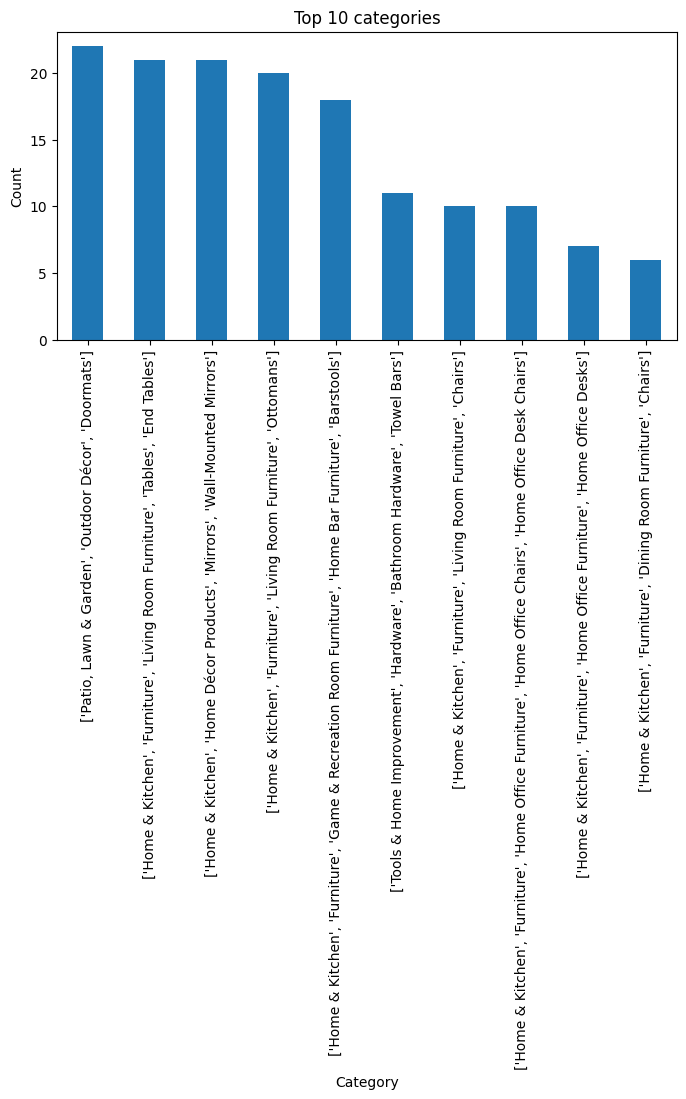

In [7]:
# Plot category distribution (top 10)
top = df['categories'].value_counts().head(10)
plt.figure(figsize=(8,4))
top.plot.bar()
plt.title("Top 10 categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
model = SentenceTransformer("all-MiniLM-L6-v2")  # small & fast

In [9]:
# compute embeddings in batches to avoid memory spikes
texts = df['text'].tolist()
BATCH = 64
embs = []
for i in range(0, len(texts), BATCH):
    batch = texts[i:i+BATCH]
    e = model.encode(batch, show_progress_bar=False, convert_to_numpy=True)
    embs.append(e)
embeddings = np.vstack(embs)
print("Embeddings shape:", embeddings.shape)
# normalize (for cosine)
embeddings = normalize(embeddings, norm='l2', axis=1)


Embeddings shape: (312, 384)


In [10]:
OUT_DIR = os.path.join("..","backend","models")
os.makedirs(OUT_DIR, exist_ok=True)
np.save(os.path.join(OUT_DIR, "embeddings.npy"), embeddings)
df.to_csv(os.path.join(OUT_DIR, "products_with_text.csv"), index=False)
print("Saved embeddings to", os.path.join(OUT_DIR,"embeddings.npy"))


Saved embeddings to ..\backend\models\embeddings.npy


In [11]:
try:
    import faiss
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # inner-product on normalized vectors = cosine
    index.add(embeddings.astype('float32'))
    # save index
    faiss.write_index(index, os.path.join(OUT_DIR, "faiss_index.idx"))
    print("Built and saved FAISS index.")
except Exception as e:
    print("FAISS not available or error:", e)
    # fallback: save embeddings + use sklearn.NearestNeighbors later
    joblib.dump({"embeddings": embeddings, "ids": df['uniq_id'].tolist()}, os.path.join(OUT_DIR, "nn_store.pkl"))
    print("Saved embeddings for sklearn fallback.")


Built and saved FAISS index.


In [12]:
# Query example: use first row text
query_text = df.loc[0, 'text']
q_emb = model.encode([query_text], convert_to_numpy=True)
q_emb = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)
k = min(6, len(df))
try:
    # faiss path
    D, I = index.search(q_emb.astype('float32'), k)
    print("Top ids:", df.loc[I[0], ['uniq_id','title']])
except:
    from sklearn.neighbors import NearestNeighbors
    store = joblib.load(os.path.join(OUT_DIR,"nn_store.pkl"))
    neigh = NearestNeighbors(n_neighbors=k, metric='cosine').fit(store['embeddings'])
    dist, idx = neigh.kneighbors(q_emb)
    print(df.iloc[idx[0]][['uniq_id','title']])


Top ids:                                   uniq_id  \
7    02593e81-5c09-5069-8516-b0b29f439ded   
0    02593e81-5c09-5069-8516-b0b29f439ded   
82   122c5c2a-5490-51ce-8555-9526c9698a38   
149  f28d5cba-ecd4-5d82-87da-d926d48e1155   
292  a10176fb-74af-5428-9aaf-2787aa4d66d2   
234  feca0b89-547f-5bca-9b97-f255c5467e47   

                                                 title  
7    GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...  
0    GOYMFK 1pc Free Standing Shoe Rack, Multi-laye...  
82   LANTEFUL Shoe Rack Organizer Shoe Storage Cabi...  
149  sogesfurniture 5 Tier Free Standing Wooden Sho...  
292  MoNiBloom Foldable Storage Free Standing Shoes...  
234  Soerreo Shoe Slot Storage Box Adjustable Shoe ...  


In [14]:
## Summary
# - Embeddings saved: `backend/models/embeddings.npy`
# - Index saved: `backend/models/faiss_index.idx` or `backend/models/nn_store.pkl`
# - Next: open `02_model_training_and_evaluation.ipynb` to evaluate retrieval and run small ML experiments.
